In [1]:
# Libraries
library(tidyverse) # for data manipulation and visualization
library(ggpubr) # or creating easily publication ready plots
library(rstatix) # provides pipe-friendly R functions for easy statistical analyses

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




# Data Generation

In [2]:
# Data generation
set.seed(111) # if you want to get the same results, you must write the same set seed.
language_scores <- sample(x = 60:100, size = 30, replace = TRUE) # Get a distribution between 60 and 100 points with 30 observation

groups <- c(rep("first_grup", 10),
         rep("second_grup", 10),
         rep("third_grup", 10))

simple_data = data.frame(groups, language_scores) # to make the series dataframe
str(simple_data)

'data.frame':	30 obs. of  2 variables:
 $ groups         : chr  "first_grup" "first_grup" "first_grup" "first_grup" ...
 $ language_scores: int  73 79 78 84 64 94 67 85 69 95 ...


# Descriptive Statistics

In [3]:
simple_data %>%
  group_by(groups) %>%
  get_summary_stats(language_scores, type = "mean_sd")

groups,variable,n,mean,sd
<chr>,<chr>,<dbl>,<dbl>,<dbl>
first_grup,language_scores,10,78.8,10.789
second_grup,language_scores,10,74.0,8.718
third_grup,language_scores,10,85.9,12.423


# Data Visualization

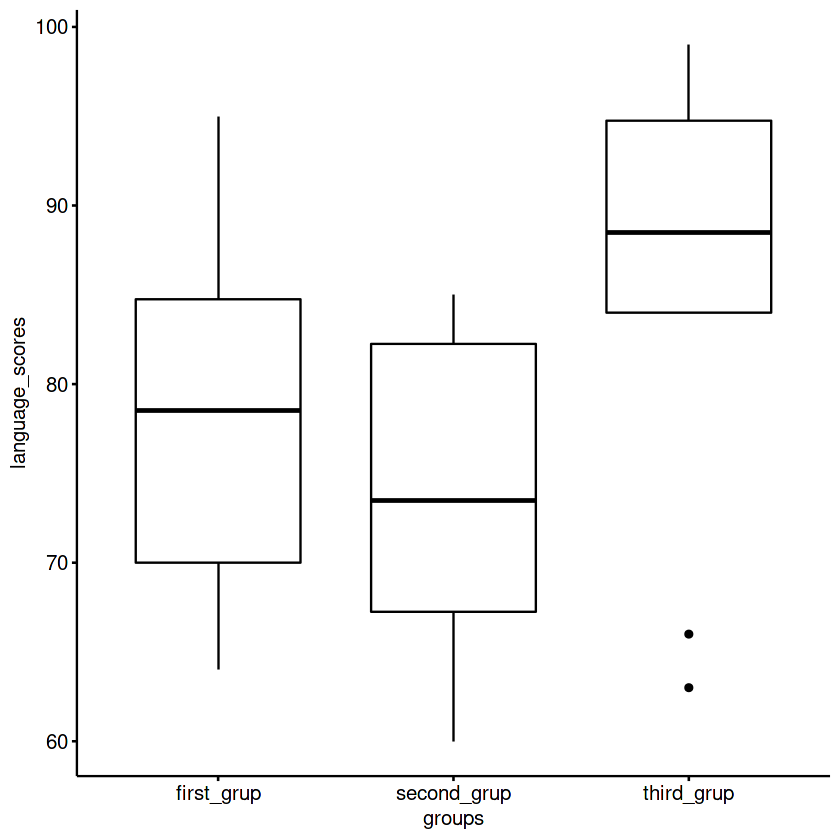

In [4]:
# qplot visualization
ggboxplot(simple_data, x = "groups", y = "language_scores")

# Assumptions
## Outliers

In [5]:
# # Outliers can be easily identified using box drawing methods with the define_outliers() function in the rstatix package.
simple_data %>% 
  group_by(groups) %>%
  identify_outliers(language_scores)

groups,language_scores,is.outlier,is.extreme
<chr>,<int>,<lgl>,<lgl>
third_grup,66,TRUE,FALSE
third_grup,63,TRUE,FALSE


There is no outlier value.

## Normality Assumption
The normality assumption can be checked using one of the following two approaches:

1. It involves analyzing ANOVA model residues together to check for normality for all groups. This approach is easier and is very useful when you have many groups or several data points (observations) per group.

2. Check for normality separately for each group. This approach can be used when you only have a few groups and many data points (observations) per group.

Let's do both option 1 and option 2.

Check the normality assumption by analyzing the model residuals. QQ chart and Shapiro-Wilk normality test were used. The QQ chart plots the correlation between a given data and the normal distribution.

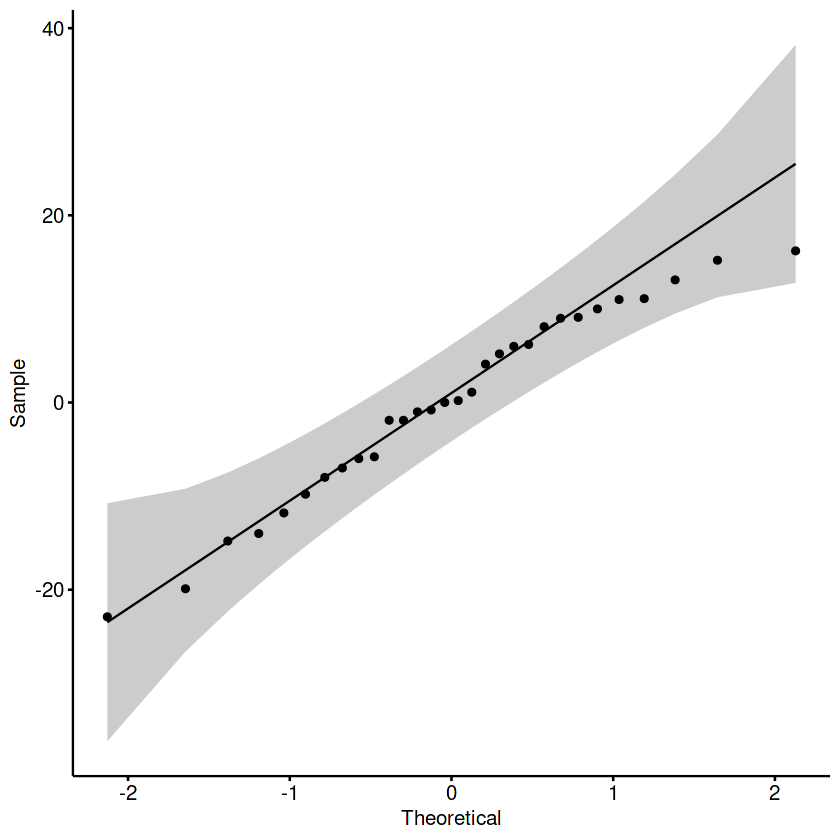

In [6]:
# Build the linear model
model  <- lm(language_scores ~ groups, data = simple_data)
# Create a QQ plot of residuals
ggqqplot(residuals(model))

In [7]:
# Shapiro-Wilk normality test
shapiro_test(residuals(model))

variable,statistic,p.value
<chr>,<dbl>,<dbl>
residuals(model),0.966617,0.4512206


In the QQ plot, we can assume normality as all points fall approximately along the reference line. This result is supported by the Shapiro-Wilk test. The p value is not significant (p = 0.45), so we can assume normality.

We check the assumption of normality by groups. Calculation of the Shapiro-Wilk test for each group level. If the data are normally distributed, the p value should be greater than 0.05.

In [8]:
simple_data %>%
  group_by(groups) %>%
  shapiro_test(language_scores)

groups,variable,statistic,p
<chr>,<chr>,<dbl>,<dbl>
first_grup,language_scores,0.9464264,0.62645539
second_grup,language_scores,0.9289730,0.43786646
third_grup,language_scores,0.8598477,0.07599371


It was normally distributed for each group as assessed by Shapiro-Wilk's test of normality (p > 0.05).


Note that if your sample size is larger than 50, the normal QQ plot is preferred because at larger sample sizes the Shapiro-Wilk test becomes very sensitive to even a small deviation from normality.

The QQ chart plots the correlation between a given data and the normal distribution. Create QQ charts for each group level:

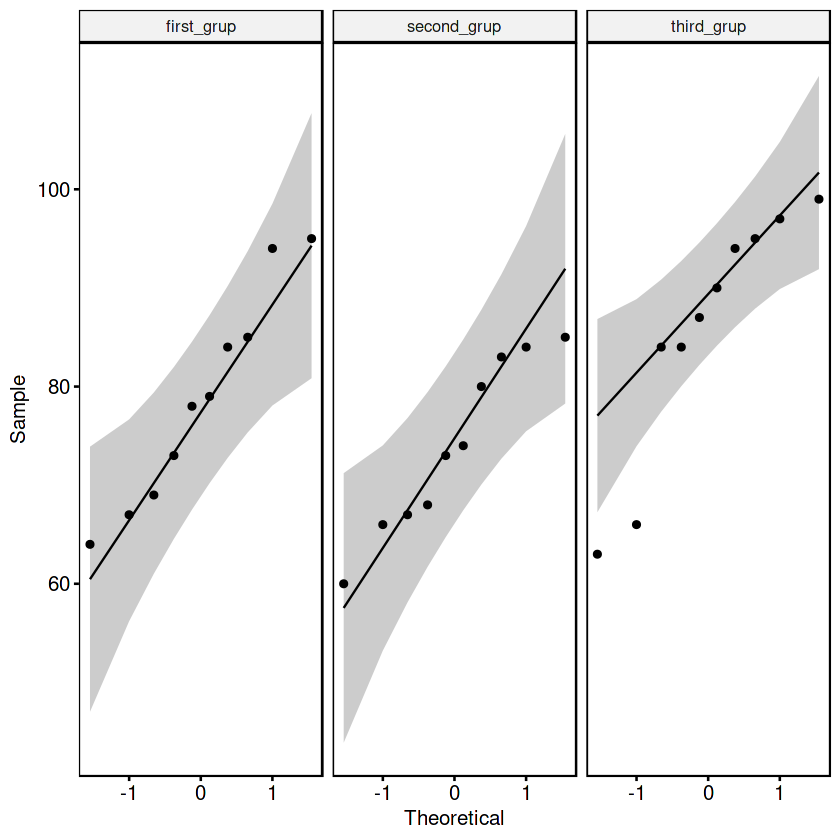

In [9]:
ggqqplot(simple_data, "language_scores", facet.by = "groups")

All points are located approximately along the reference line for each cell. Thus, we can assume that the data are normally distributed.

**Note:** If you are in doubt about the normality of the data, you can use the Kruskal-Wallis test, which is a non-parametric alternative to the one-way ANOVA test.

## Homogeneity of Variance 
1. The residuals-fit plot can be used to check the homogeneity of the variances.

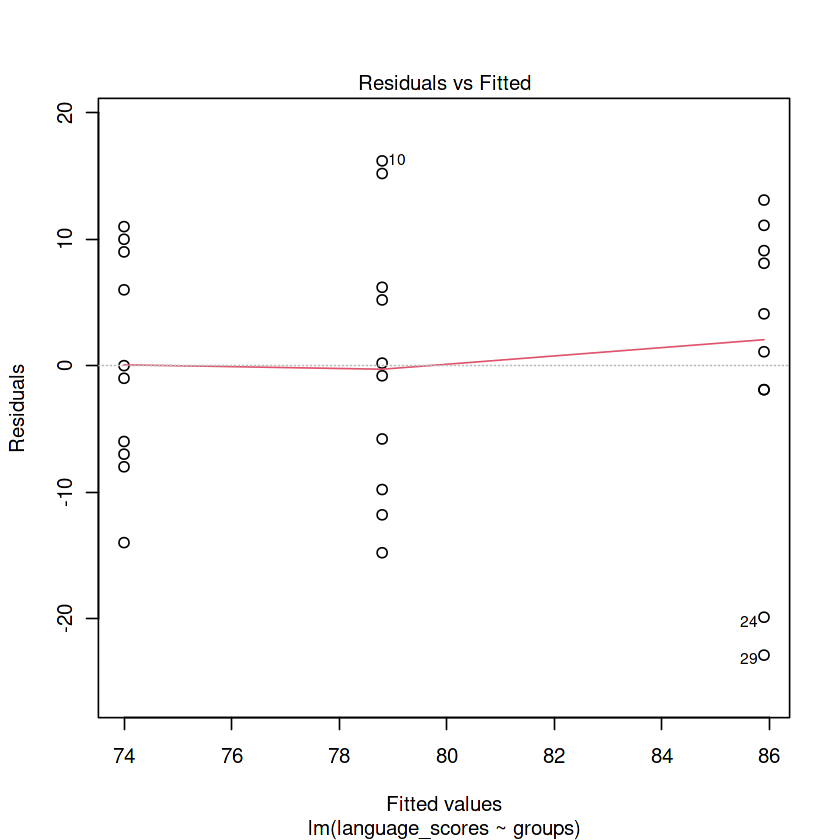

In [10]:
plot(model, 1)

In the graph above, there is no obvious relationship between residuals and fit values (mean of each group), which is fine. So we can assume homogeneity of variances.

It is also possible to use the Levene test to check for homogeneity of variances:

In [11]:
# Levene Test
simple_data %>% levene_test(language_scores ~ groups)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,27,0.2369278,0.7906715


From the above output we can see that the p-value is > 0.05, which is not significant. This means that there is no significant difference in variances between groups. Therefore, group variance homogeneity is also ensured.

In a situation where the variance homogeneity assumption is not met, you can use the Welch one-way ANOVA test using the welch_anova_test()[rstatix package] function. This test does not require the equal variance assumption.

In [12]:
res.aov <- simple_data %>% anova_test(language_scores ~ groups)
res.aov


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,groups,2,27,3.101,0.061,,0.187


Since the p value is greater than p > 0.05, it is seen that there is no significant difference between the groups.

In the table above, the ges column corresponds to the generalized eta square, that is, the effect size. It measures the proportion of variability in the outcome variable (language score) that can be explained in terms of the predictor (group). An effect size of 0.18 (18%) means that 18% of the variation in weight can be explained for the language score.

# References
* https://statsandr.com/blog/anova-in-r/
* https://www.datanovia.com/en/lessons/anova-in-r/
* İstatistikten Nefret Edenler İçin İstatistik - Neil Salkind